# Setup




Parameters are shown in papers linked below.

1. [Durstewitz et. al., 2000 ](https://papers.cnl.salk.edu/PDFs/Dopamine-Mediated%20Stabilization%20of%20Delay-Period%20Activity%20in%20a%20Network%20Model%20of%20Prefrontal%20Cortex%202000-3711.pdf)
(Synaptic conductance; 근데 밑에 class 제작할 때는 2002 논문 parameter 사용?)

2. [Durstewitz et. al., 2002](https://www.bio.psy.ruhr-uni-bochum.de/bpsy/mam/content/documents/durstewitz_2002_the_computational_role_of_dopamine_d1.pdf)
(Morphology ~ Ionic conductance)

3. [Otani. et al, 2011](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=3f57d0ce041ff40785912241a47c9e9d2a528bba) (+0.001 term in soma_IKS, desired peak conductance)

4. [Tsodyks, M. V., & Markram, H. (1997)](https://www.pnas.org/doi/pdf/10.1073/pnas.94.2.719), [Durstewitz, D., & Gabriel, T. (2007)](https://academic.oup.com/cercor/article-abstract/17/4/894/377757) (utilization of syn_ampa_ampaaptic efficacy (USE) & recovery time)

In [1]:
from neuron import h
import numpy as np
import matplotlib.pyplot as plt
from neuron.units import ms, mV, µm
from matplotlib.gridspec import GridSpec

In [2]:
### Morphology ###

soma_l = 28.62
soma_d = 21.84

dend_l = 650
dend_d = 6.5

### Passive properties ###

soma_Rm = 30000     # membrane resistance
soma_Eleak = -70    # leakage reversal potential
soma_Cm = 1.2       # membrane capacitance
soma_Ri = 150       # axial resistance

dend_Rm = soma_Rm / 1.92
dend_Eleak = -70
dend_Cm = soma_Cm * 1.92 
dend_Ri = 150

### Ionic conductances ###

soma_INa = 0.117      # Na+ current
soma_INaP = 0.0018     # persistent Na+ current
soma_IDR = 0.05       # delayed rectifier current
soma_IKS = 8e-5 + 0.001     # slowly inactivating K+ current
soma_IC = 0.0021       # voltage-dependent C-type K+ current
soma_IHVA = 0.0004     # high-voltage-activated Ca2+ current

dend_INa = 0.02
dend_INaP = 0.0008
dend_IDR = 0.014
dend_IKS = soma_IKS
dend_IC = soma_IC
dend_IHVA = 0.0008

CAF = 600e-9   # calcium accumulation factor

### Plasticity parameters ###

ampa_tau1 = 0.55  # ms
ampa_tau2 = 2.2   # ms

nmda_taus = 0.1
nmda_tau1 = 10.6   # ms
nmda_tau2 = 285.0  # ms

### Desired peak conductances

g_AMPA_max = 0.004  # uS
g_NMDA_max = g_AMPA_max / 50    # uS

USE = 0.6       # STD utilization parameter 
t_rec = 800     # recovery time (ms)


In [3]:
h.load_file('stdrun.hoc')

### load ionic conductances ###

h.nrn_load_dll("./mods/arm64/.libs/libnrnmech.so")
# mechanisms = ['hh', 'kdr', 'iks', 'hva', 'ic', 'cadyn']
mechanisms = ['naf', 'nap', 'hva','kdr', 'iks', 'hva', 'ic', 'cadyn', 'kdyn']

# Generate Two-Compartment Model Neuron

In [4]:
### Create a soma ###

soma = h.Section(name='soma')

### Add morphology ###

soma.L = soma_l
soma.diam = soma_d

### Add passive properties ###

soma.insert('pas')
soma.g_pas = 1 / soma_Rm
soma.e_pas = soma_Eleak
soma.Ra = soma_Ri
soma.cm = soma_Cm

### Add ionic conductances ###

for i in mechanisms:
    soma.insert(i)

soma(0.5).nap.gnapbar = soma_INaP
soma(0.5).naf.gnafbar = soma_INa
soma(0.5).hva.ghvabar = soma_IHVA
soma(0.5).kdr.gkdrbar = soma_IDR
soma(0.5).iks.gKsbar = soma_IKS
soma(0.5).ic.gkcbar = soma_IC
soma(0.5).cadyn.CAF = CAF

In [5]:
### Create a dendrite ###

dend = h.Section(name='dend')

### Add morphology ###

dend.L = dend_l
dend.diam = dend_d

### Add passive properties ###

dend.insert('pas')  # Passive dendrite
dend.g_pas = 1 / dend_Rm
dend.e_pas = dend_Eleak
dend.Ra = dend_Ri
dend.cm = dend_Cm

# Add ionic conductances

for i in mechanisms:
    dend.insert(i)

dend(0.5).nap.gnapbar = dend_INaP
dend(0.5).naf.gnafbar = dend_INa
dend(0.5).hva.ghvabar = dend_IHVA
dend(0.5).kdr.gkdrbar = dend_IDR
dend(0.5).iks.gKsbar = dend_IKS
dend(0.5).ic.gkcbar = dend_IC
dend(0.5).cadyn.CAF = CAF

### Connect soma and dendrite ###
dend.connect(soma)

dend

# Checking Ionic Currents

In [6]:
# Insert your NMDA synapse
syn_nmda = h.nmda(dend(0.5))
syn_nmda.tau1 = nmda_tau1
syn_nmda.tau2 = nmda_tau2
syn_nmda.gmax = g_NMDA_max # uS
syn_nmda.e = 0  # mV

# Insert your AMPA synapse
syn_ampa = h.ampa(dend(0.5))
syn_ampa.tau1 = ampa_tau1
syn_ampa.tau2 = ampa_tau2
syn_ampa.gmax = g_AMPA_max  # uS
syn_ampa.e = 0  # mV

In [7]:
### Stimulation condition ###

stim = h.IClamp(dend(0.5))
stim.delay = 100
stim.dur = 500
stim.amp = 0.4

In [8]:
### Time & voltage recording ###

t = h.Vector().record(h._ref_t)
dend_v = h.Vector().record(dend(0.5)._ref_v)
soma_v =  h.Vector().record(soma(0.5)._ref_v)


In [9]:
### Soma recording ###

soma_ina_vec = h.Vector().record(soma(0.5).na_ion._ref_ina)
soma_ena_vec = h.Vector().record(soma(0.5).na_ion._ref_ena)
soma_nai_vec = h.Vector().record(soma(0.5).na_ion._ref_nai)
soma_nao_vec = h.Vector().record(soma(0.5).na_ion._ref_nao)

soma_ik_vec = h.Vector().record(soma(0.5).k_ion._ref_ik)
soma_ki_vec = h.Vector().record(soma(0.5).k_ion._ref_ki)
soma_ek_vec = h.Vector().record(soma(0.5).k_ion._ref_ek)

soma_cai_vec = h.Vector().record(soma(0.5).ca_ion._ref_cai)
soma_cao_vec = h.Vector().record(soma(0.5).ca_ion._ref_cao)
soma_ica_vec = h.Vector().record(soma(0.5).ca_ion._ref_ica)
soma_eca_vec = h.Vector().record(soma(0.5).ca_ion._ref_eca)

### Dendrite recording ###

dend_ina_vec = h.Vector().record(dend(0.5).na_ion._ref_ina)
dend_ena_vec = h.Vector().record(dend(0.5).na_ion._ref_ena)
dend_nai_vec = h.Vector().record(dend(0.5).na_ion._ref_nai)
dend_nao_vec = h.Vector().record(dend(0.5).na_ion._ref_nao)

dend_ik_vec = h.Vector().record(dend(0.5).k_ion._ref_ik)
dend_ki_vec = h.Vector().record(dend(0.5).k_ion._ref_ki)
dend_ek_vec = h.Vector().record(dend(0.5).k_ion._ref_ek)

dend_cai_vec = h.Vector().record(dend(0.5).ca_ion._ref_cai)
dend_cao_vec = h.Vector().record(dend(0.5).ca_ion._ref_cao)
dend_ica_vec = h.Vector().record(dend(0.5).ca_ion._ref_ica)
dend_eca_vec = h.Vector().record(dend(0.5).ca_ion._ref_eca)


In [10]:
### Gating variables and conductance recording ###

nap = soma(0.5).nap
naf = soma(0.5).naf
iks = soma(0.5).iks
hva = soma(0.5).hva
kdr = soma(0.5).kdr
ic = soma(0.5).ic

naf_m_vec = h.Vector().record(naf._ref_m)
naf_h_vec = h.Vector().record(naf._ref_h)
naf_g_vec = h.Vector().record(naf._ref_gna)

nap_m_vec = h.Vector().record(nap._ref_m)
nap_h_vec = h.Vector().record(nap._ref_h)
nap_g_vec = h.Vector().record(nap._ref_gna)

hva_u_vec = h.Vector().record(hva._ref_u)
hva_z_vec = h.Vector().record(hva._ref_z)
hva_g_vec = h.Vector().record(hva._ref_gca)

kdr_n_vec = h.Vector().record(kdr._ref_n)
kdr_g_vec = h.Vector().record(kdr._ref_gk)

iks_a_vec = h.Vector().record(iks._ref_a)
iks_b_vec = h.Vector().record(iks._ref_b)
iks_g_vec = h.Vector().record(iks._ref_gk)

ic_c_vec = h.Vector().record(ic._ref_c)
ic_g_vec = h.Vector().record(ic._ref_gk)


In [ ]:
### Run simulation ###

h.finitialize(-65 * mV)
h.continuerun(1000 * ms)

0.0

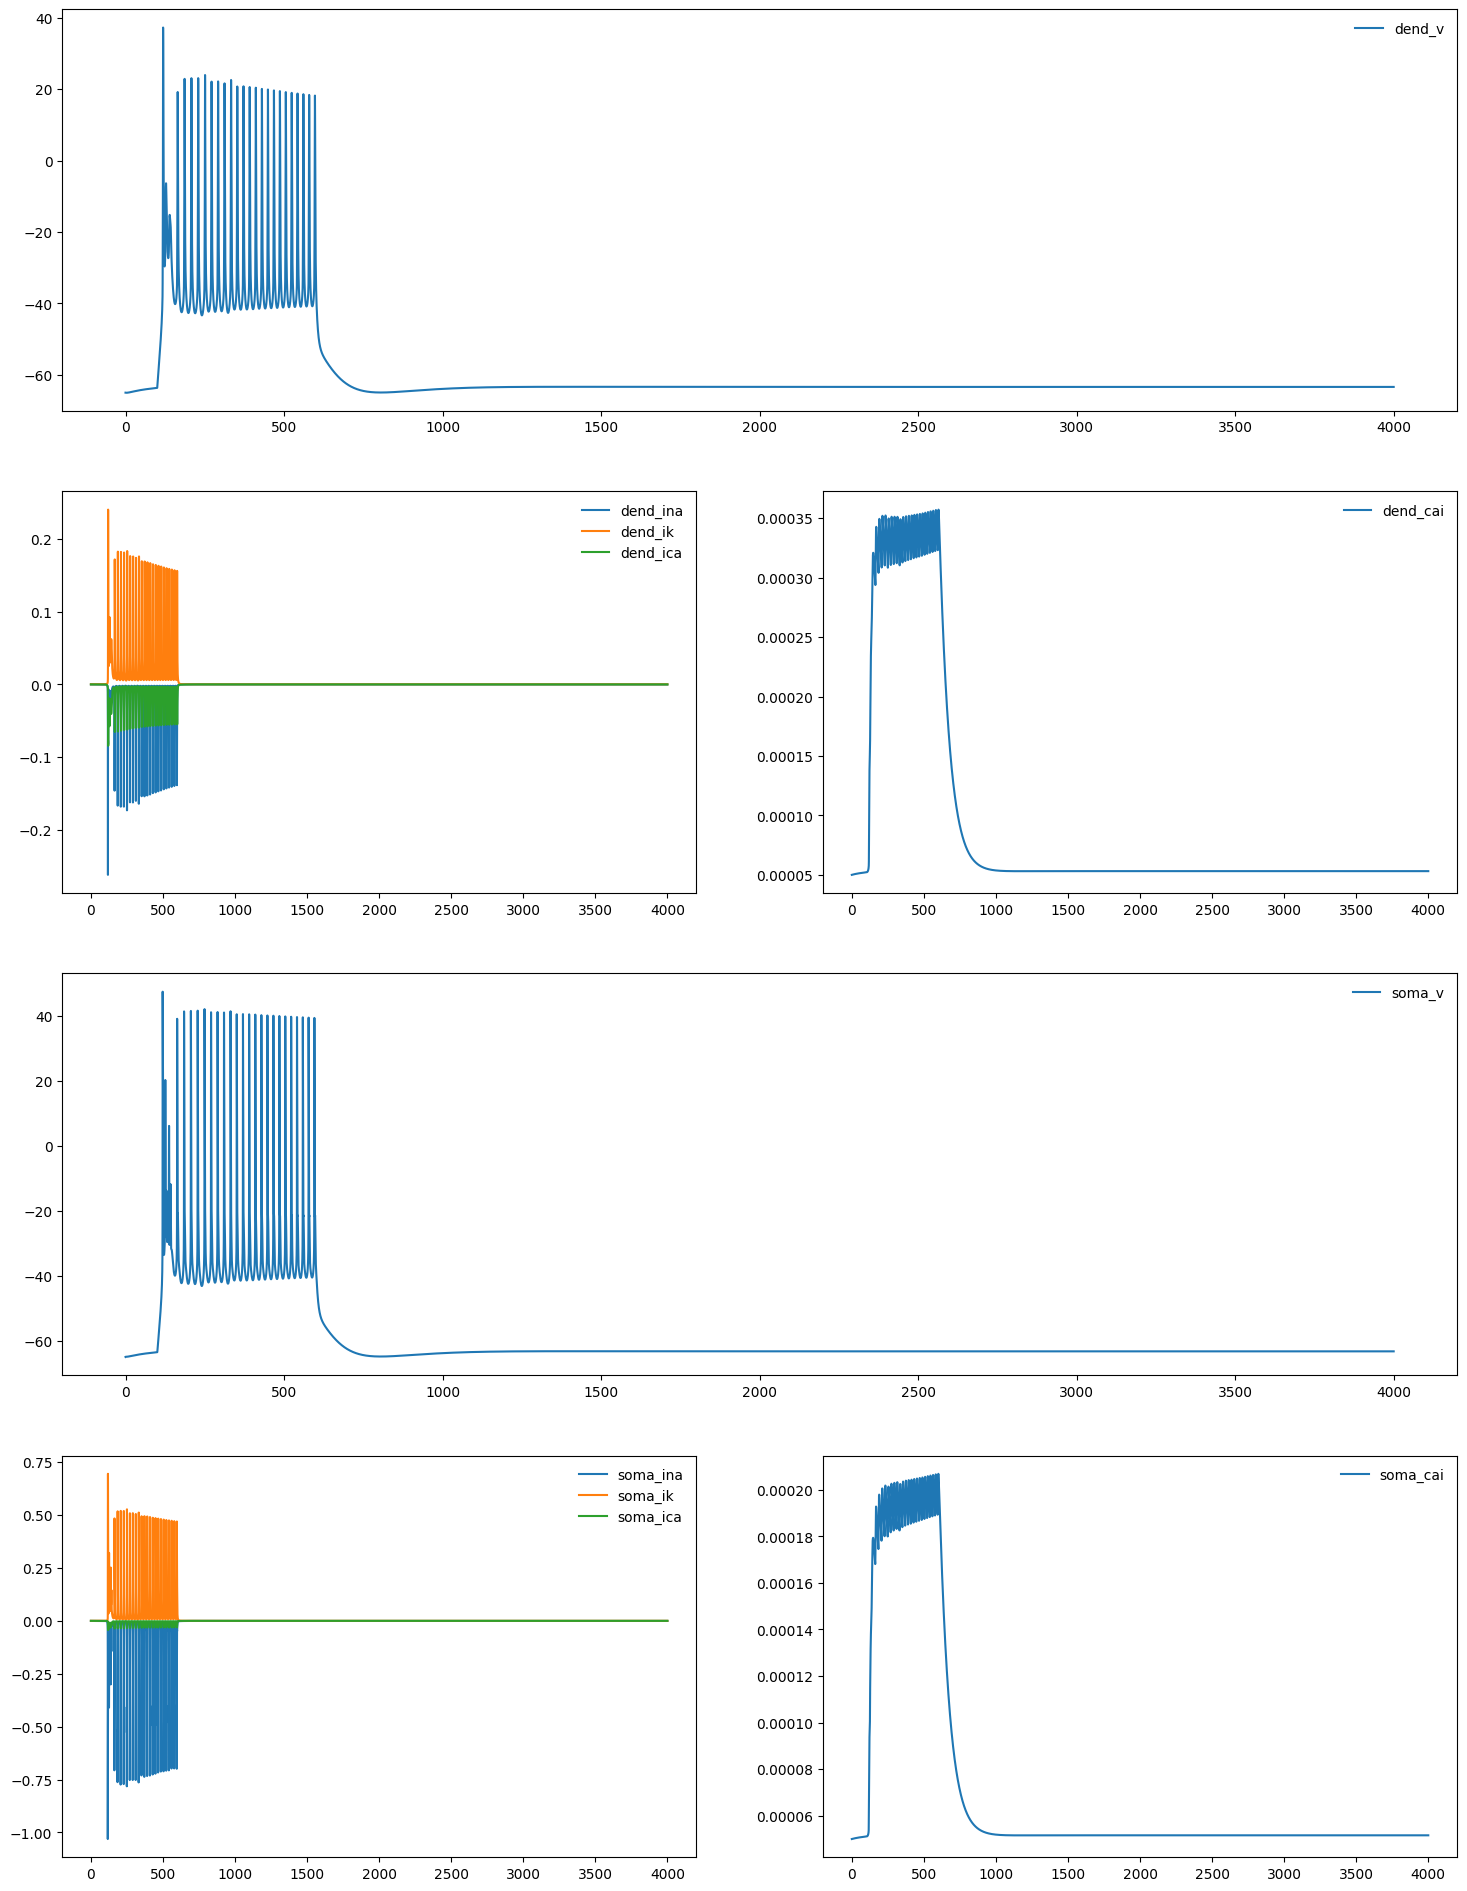

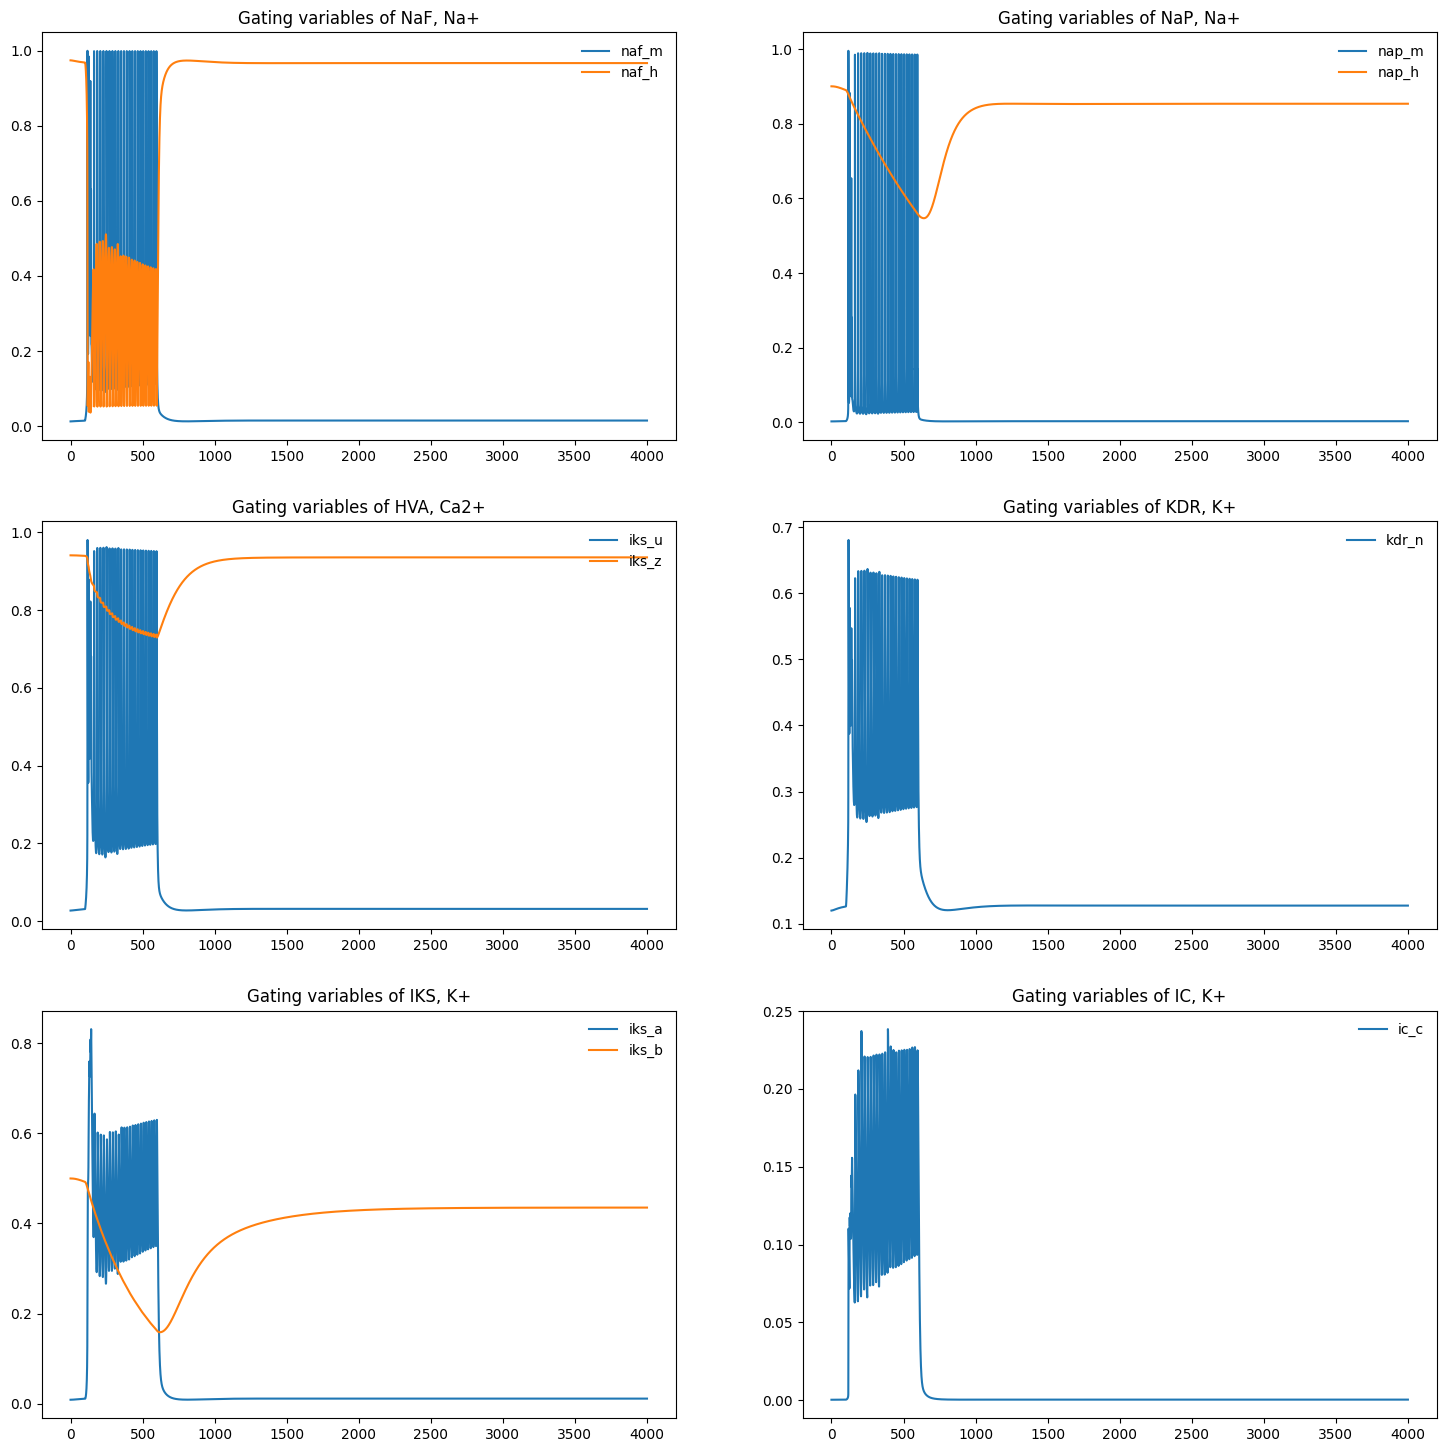

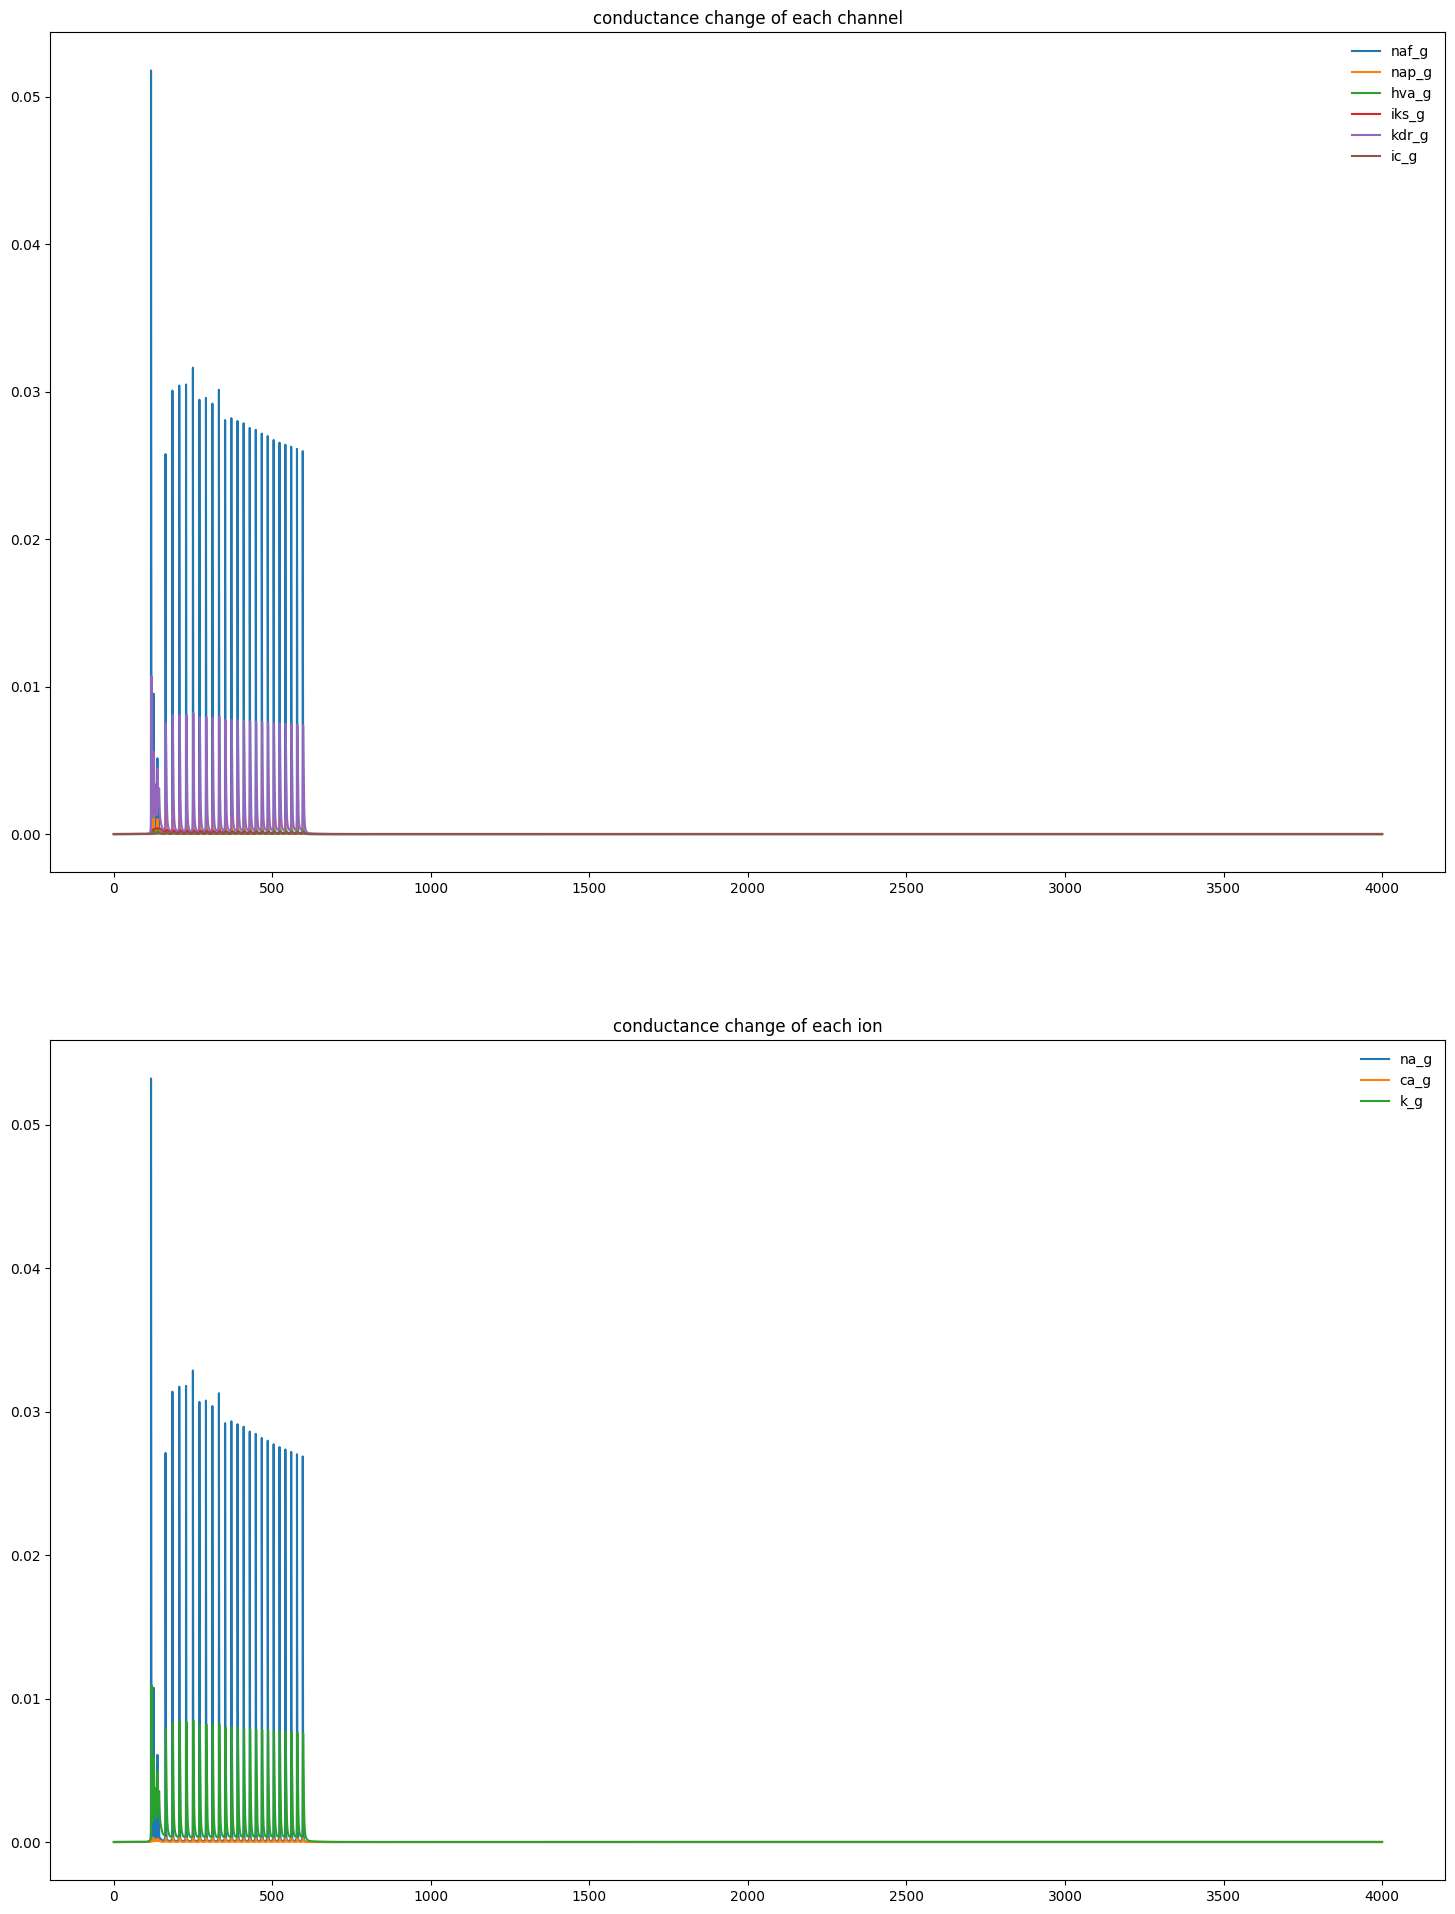

In [12]:
### Plot currents and membrane potential ###

plt.figure(figsize=(18,24))

gs1=GridSpec(4,2)

plt.subplot(gs1[0,:])
plt.plot(t, dend_v, label='dend_v')
plt.legend(loc='upper right',fontsize=10, framealpha=0.0)

plt.subplot(gs1[1,0])
plt.plot(t, dend_ina_vec, label='dend_ina')
plt.plot(t, dend_ik_vec, label='dend_ik')
plt.plot(t, dend_ica_vec, label='dend_ica')
plt.legend(loc='upper right',fontsize=10, framealpha=0.0)

plt.subplot(gs1[1,1])
plt.plot(t, dend_cai_vec, label='dend_cai')
plt.legend(loc='upper right',fontsize=10, framealpha=0.0)

plt.subplot(gs1[2,:])
plt.plot(t, soma_v, label='soma_v')
plt.legend(loc='upper right',fontsize=10, framealpha=0.0)

plt.subplot(gs1[3,0])
plt.plot(t, soma_ina_vec, label='soma_ina')
plt.plot(t, soma_ik_vec, label='soma_ik')
plt.plot(t, soma_ica_vec, label='soma_ica')
plt.legend(loc='upper right',fontsize=10, framealpha=0.0)  

plt.subplot(gs1[3,1])
plt.plot(t, soma_cai_vec, label='soma_cai')
plt.legend(loc='upper right',fontsize=10, framealpha=0.0)

### Plot gating variables ###

gs2=GridSpec(3,2)
plt.figure(figsize=(18,18))

# Gating variables in soma(0.5)
plt.subplot(gs2[0,0])
plt.title("Gating variables of NaF, Na+")
plt.plot(t, naf_m_vec, label='naf_m')
plt.plot(t, naf_h_vec, label='naf_h')
plt.legend(loc='upper right',fontsize=10, framealpha=0.0)

plt.subplot(gs2[0,1])
plt.title("Gating variables of NaP, Na+")
plt.plot(t, nap_m_vec, label='nap_m')
plt.plot(t, nap_h_vec, label='nap_h')
plt.legend(loc='upper right',fontsize=10, framealpha=0.0)

plt.subplot(gs2[1,0])
plt.title("Gating variables of HVA, Ca2+")
plt.plot(t, hva_u_vec, label='iks_u')
plt.plot(t, hva_z_vec, label='iks_z')
plt.legend(loc='upper right',fontsize=10, framealpha=0.0)

plt.subplot(gs2[1,1])
plt.title("Gating variables of KDR, K+")
plt.plot(t, kdr_n_vec, label='kdr_n')
plt.legend(loc='upper right',fontsize=10, framealpha=0.0)

plt.subplot(gs2[2,0])
plt.title("Gating variables of IKS, K+")
plt.plot(t, iks_a_vec, label='iks_a')
plt.plot(t, iks_b_vec, label='iks_b')
plt.legend(loc='upper right',fontsize=10, framealpha=0.0)

plt.subplot(gs2[2,1])
plt.title("Gating variables of IC, K+")
plt.plot(t, ic_c_vec, label='ic_c')
plt.legend(loc='upper right',fontsize=10, framealpha=0.0)

# fig.tight_layout(pad=1.0)

# fig2=plt.gcf()
# fig2.savefig('./gating_variables_plot.png', dpi=100)

gs3=GridSpec(2,1)
plt.figure(figsize=(18,24))

plt.subplot(gs3[0,:])
plt.title("conductance change of each channel")
plt.plot(t, naf_g_vec, label='naf_g')
plt.plot(t, nap_g_vec, label='nap_g')
plt.plot(t, hva_g_vec, label='hva_g')
plt.plot(t, iks_g_vec, label='iks_g')
plt.plot(t, kdr_g_vec, label='kdr_g')
plt.plot(t, ic_g_vec, label='ic_g')
plt.legend(loc='upper right',fontsize=10, framealpha=0.0)

plt.subplot(gs3[1,:])
plt.title("conductance change of each ion")
plt.plot(t, naf_g_vec+nap_g_vec, label='na_g')
plt.plot(t, hva_g_vec, label='ca_g')
plt.plot(t, iks_g_vec+kdr_g_vec+ic_g_vec, label='k_g')
plt.legend(loc='upper right',fontsize=10, framealpha=0.0)
# fig3=plt.gcf()
# fig3.savefig('./conductance_plot.png', dpi=100)

# Create Synpase

In [13]:
# Insert your NMDA synapse
syn_nmda = h.nmda(dend(0.5))
syn_nmda.tau1 = nmda_tau1
syn_nmda.tau2 = nmda_tau2
syn_nmda.gmax = g_NMDA_max # uS
syn_nmda.e = 0  # mV

# Insert your AMPA synapse
syn_ampa = h.ampa(dend(0.5))
syn_ampa.tau1 = 0.55
syn_ampa.tau2 = 2.2
syn_ampa.e = 0  # mV
syn_ampa.gmax = g_AMPA_max  # uS

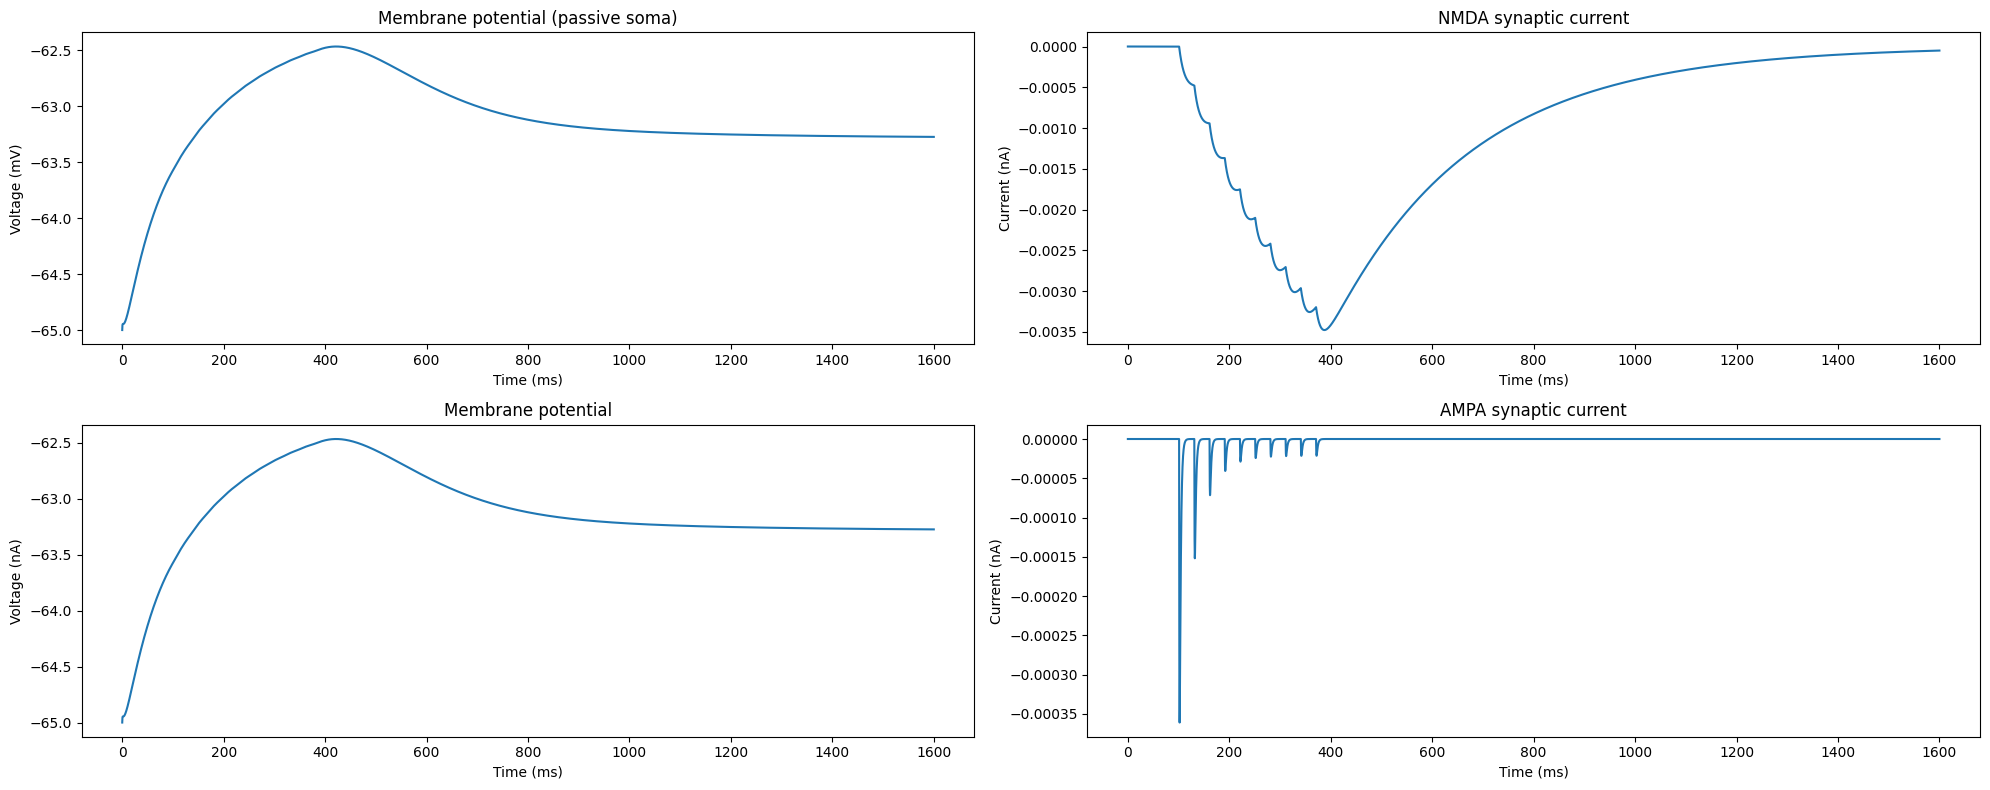

In [14]:
# Stimulate it with NetStim + NetCon
stim = h.NetStim()
stim.start = 100  # ms
stim.number = 10
stim.interval = 30
stim.noise = 0

nc_nmda = h.NetCon(stim, syn_nmda)  # weight is fixed inside mod file
nc_nmda.weight[0] = 1  # In uS (must match units in mod file)
nc_ampa = h.NetCon(stim, syn_ampa)  # weight is fixed inside mod file
nc_ampa.weight[0] = 0.005  # In uS (must match units in mod file)

# Record membrane voltage and synaptic current
v_nmda = h.Vector().record(soma(0.5)._ref_v)
i_nmda = h.Vector().record(syn_nmda._ref_i)
t = h.Vector().record(h._ref_t)

# Record membrane voltage and synaptic current
v_ampa = h.Vector().record(soma(0.5)._ref_v)
i_ampa = h.Vector().record(syn_ampa._ref_i)
t_ampa = h.Vector().record(h._ref_t)

# Run simulation
h.finitialize(-65)
h.continuerun(1600)

# Plot results
plt.figure(figsize=(20, 8))
plt.subplot(2, 2, 1)
plt.plot(t, v_nmda)
plt.title("Membrane potential (passive soma)")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")

plt.subplot(2, 2, 2)
plt.plot(t, i_nmda)
plt.title("NMDA synaptic current")
plt.xlabel("Time (ms)")
plt.ylabel("Current (nA)")

plt.subplot(2, 2, 3)
plt.plot(t, v_ampa)
plt.title("Membrane potential")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (nA)")

plt.subplot(2, 2, 4)
plt.plot(t, i_ampa)
plt.title("AMPA synaptic current")
plt.xlabel("Time (ms)")
plt.ylabel("Current (nA)")
plt.tight_layout()
plt.show()

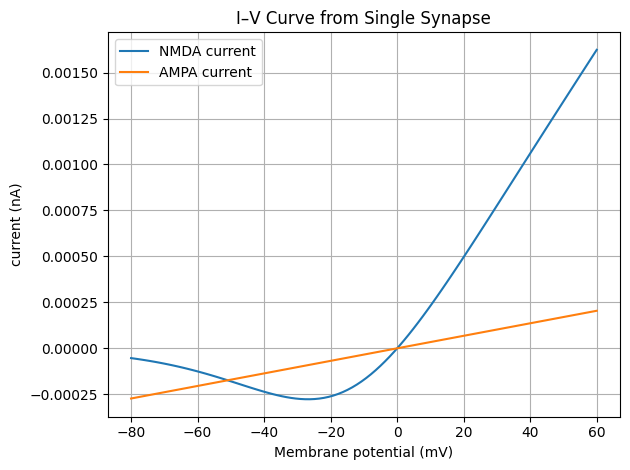

In [15]:
# NetStim
stim = h.NetStim()
stim.start = 10
stim.number = 10
stim.interval = 10
stim.noise = 0

nc_ampa = h.NetCon(stim, syn_ampa)
nc_nmda = h.NetCon(stim, syn_nmda)
nc_ampa.weight[0] = 0.005
nc_nmda.weight[0] = 1

# Voltage clamp
clamp = h.SEClamp(dend(0.5))
clamp.dur1 = 40
clamp.dur2 = 0
clamp.dur3 = 0
clamp.rs = 1e-3


voltages = np.linspace(-80, 60, 100)  # mV
nmda_currents = []
ampa_currents = []

for v in voltages:
    clamp.amp1 = v

    t_vec = h.Vector().record(h._ref_t)
    i_nmda_vec = h.Vector().record(syn_nmda._ref_i)
    i_ampa_vec = h.Vector().record(syn_ampa._ref_i)

    h.finitialize(-65)
    h.continuerun(100)

    # Extract current after synaptic activation
    t = np.array(t_vec)
    i_nmda = np.array(i_nmda_vec)
    i_ampa = np.array(i_ampa_vec)
    mask = (t > 11) & (t < 16)  # after stimulation
    nmda_avg_i = np.mean(i_nmda[mask])
    ampa_avg_i = np.mean(i_ampa[mask])
    nmda_currents.append(nmda_avg_i)
    ampa_currents.append(ampa_avg_i)

# Plot IV
plt.figure()
plt.plot(voltages, nmda_currents, label='NMDA current')
plt.plot(voltages, ampa_currents, label = 'AMPA current')
plt.title("I–V Curve from Single Synapse")
plt.xlabel("Membrane potential (mV)")
plt.ylabel("current (nA)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Archived Codes


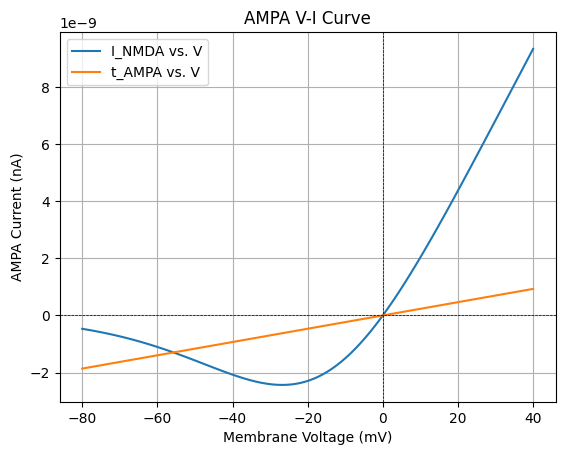

In [16]:
from neuron import h

class Synapse:
    def __init__(self, sec, weight=1.0):
        
        # Create AMPA synapse
        self.ampa = h.Exp2Syn(sec)
        self.ampa.tau1 = 0.2  # AMPA time constant 1 (ms)
        self.ampa.tau2 = 1.0  # AMPA time constant 2 (ms)
        self.ampa.e = 0.0  # AMPA reversal potential (mV)
        self.ampa_g_max = 4e-9
        
        # Create NMDA synapse
        self.nmda = h.Exp2Syn(sec)
        self.nmda.tau1 = 2.3  # NMDA time constant 1 (ms)
        self.nmda.tau2 = 95.0  # NMDA time constant 2 (ms)
        self.nmda.e = 0.0  # NMDA reversal potential (mV)
        self.nmda_g_max = 4e-9 / 50

        # Weight parameters
        self.ampa_weight = weight
        self.nmda_weight = 1.0  # Fixed efficacy for NMDA
        
        # Short-term depression parameters
        self.use = 0.3  # Utilization parameter
        self.t_rec = 800  # Recovery time constant (ms)
        self.residual_depression = 1.0  # Tracks depression state
        
        # Voltage-dependent NMDA gating from Mel (1993)
        self.tau_s = 0.1  # Time constant for Mg²⁺ block kinetics
        
    def nmda_gating(self, v):
        
        # voltage-dependent Mg2+ gating
        return 1.50265 / (1 + 0.33 * h.exp(-0.06 * v))
    
    def update_ampa(self, presynaptic_input, v):
        
        # Update AMPA conductance with plasticity and short-term depression
        self.residual_depression *= (1 - self.use)  # Apply depression
        self.ampa_g = self.ampa_g_max *  self.ampa_weight * presynaptic_input * self.residual_depression
        self.ampa_current = self.ampa_g * (v - self.ampa.e) 
    
    def update_nmda(self, presynaptic_input, v):
        
        # Update NMDA conductance with voltage-dependent gating and compute current
        mg_block = self.nmda_gating(v)
        self.nmda_g = self.nmda_weight * mg_block * presynaptic_input
        self.nmda_current = self.nmda_g_max * self.nmda_g * (v - self.nmda.e)  # I_NMDA = g_NMDA * s(V) * (V - E_NMDA)
    
    def recover_depression(self, dt):
        """Recover synaptic depression over time."""
        self.residual_depression += (1.0 - self.residual_depression) * (dt / self.t_rec)
            
    def update(self, presynaptic_input, v, dt):
        """Update both AMPA and NMDA conductances, including short-term depression recovery."""
        self.update_ampa(presynaptic_input, v)
        self.update_nmda(presynaptic_input, v)
        self.recover_depression(dt)

# Example usage
syn = Synapse(dend(0.5))

# syn.update(2.0, -65, 1.0)  # Example presynaptic input of 1.0, Vm=-65 mV, timestep dt=1.0 ms
# print(f"NMDA Conductance: {syn.nmda_g}, NMDA Current: {syn.nmda_current}")

# Define voltage range from -80 mV to +40 mV
voltages = np.linspace(-80, 40, 100)  # 100 points between -80 and 40 mV
nmda_currents = []
ampa_currents = []



for v in voltages:
    syn.update(2.0, v, 1.0)  # Presynaptic input = 2.0, timestep dt = 1.0 ms
     # AMPA current calculation
    nmda_currents.append(syn.nmda_current)
    
# Loop through voltage values and compute AMPA current
for v in voltages:
    syn.update(2.0, v, 1.0)  # Presynaptic input = 2.0, timestep dt = 1.0 ms
     # AMPA current calculation
    ampa_currents.append(syn.ampa_current)



# Plot V-I curve
plt.plot(voltages, nmda_currents, label="I_NMDA vs. V")
plt.plot(voltages, ampa_currents, label="t_AMPA vs. V")
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)  # Zero current reference
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)  # Zero voltage reference
plt.xlabel("Membrane Voltage (mV)")
plt.ylabel("AMPA Current (nA)")
plt.title("AMPA V-I Curve")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# import numpy as np

# class NMDASynapse:
#     def __init__(self, sec, weight=1.0):
#         self.sec = sec
#         self.loc = sec(0.5)
#         self.nmda_g_max = 4e-9 / 50  # max conductance
#         self.nmda_weight = weight

#         # Time constants
#         self.tau1 = 2.3
#         self.tau2 = 95.0

#         self.e_rev = 0.0
#         self.use = 0.6
#         self.t_rec = 800.0  # ms
#         self.tau_s = 0.1

#         self.spike_times = [0]  # times of presynaptic activation

#         self.g_nmda_vec = []  # store conductance for plotting/debug
#         self.i_nmda_vec = []  # store current for plotting/debug
#         self.v_nmda_vec = []  # store voltage for plotting/debug
#         self.time_vec = []

#     def nmda_gating(self, v):
#         return 1.50265 / (1 + 0.33 * np.exp(-0.0625 * v))

#     def activate(self, t_spike):

#         self.spike_times.append(t_spike)
#         print(self.spike_times)

#     def compute_g(self, t):
#         g_total = 0
#         for t0 in self.spike_times:
#             if t >= t0:
#                 dt = t - t0
#                 g = self.nmda_weight * (np.exp(-dt / self.tau2) - np.exp(-dt / self.tau1))
#                 g_total += max(g, 0)
#         return g_total

#     def update(self, t, v):
#         g = self.compute_g(t)
#         mg_block = self.nmda_gating(v)
#         i_nmda = self.nmda_g_max * g * mg_block * (v - self.e_rev)

#         # Store for analysis
#         self.g_nmda_vec.append(g)
#         self.i_nmda_vec.append(i_nmda)
#         self.time_vec.append(t)
        
#         return self.i_nmda_vec, self.g_nmda_vec


In [18]:
# stim = h.IClamp(dend(0.5))

# stim.delay = 100
# stim.dur = 500
# stim.amp = 0.4

# syn = NMDASynapse(soma)

# v_dend = h.Vector().record(soma(0.5)._ref_v)             # Membrane potential vector
# t_dend = h.Vector().record(h._ref_t)

# h.finitialize(-65 * mV)
# h.continuerun(100 * ms)
# # print(np.array(v_dend))

# refractory_period = 2

# for i, v in enumerate(np.array(v_dend)):
    
#     spike_time = 0

#     if v > 30:
        
#         spike_time = np.array(t_dend)[i]
        
#         if np.array(t_dend)[i] - syn.spike_times[-1] > refractory_period : 

#             syn.activate(spike_time)

        
#     conductance, current  = syn.update(np.array(t_dend)[i], v)
    
# # v_soma = h.Vector().record(soma(0.5)._ref_v)
# # t_soma = h.Vector().record(h._ref_t)

# h.finitialize(-65 * mV)
# h.continuerun(1000 * ms)

# v_nmda_vec = []

# for i, cur in enumerate(current):
#     v_nmda_vec.append(cur / conductance[i])

# # print(np.array(v_soma))

# # # v = h.Vector().record(soma(0.5)._ref_v)             # Membrane potential vector
# # # t = h.Vector().record(h._ref_t)                     # Time stamp vector

# plt.plot(v_nmda_vec ,  label="t_AMPA vs. V")
# plt.show()

In [19]:
# class NMDASynapse:
#     def __init__(self, sec, weight=1.0):
#         # Create NMDA synapse
#         self.nmda = h.Exp2Syn(sec(0.5))
#         self.nmda.tau1 = 2.3 * ms  # NMDA time constant 1 (ms)
#         self.nmda.tau2 = 95.0 * ms  # NMDA time constant 2 (ms)
#         self.nmda.e = 0.0 * mV  # NMDA reversal potential (mV)
#         self.nmda_g_max = 4e-9 / 50
        
#         # Weight parameters
#         self.nmda_weight = 1.0  # Fixed efficacy for NMDA
        
#         # Short-term depression parameters
#         self.use = 0.6  # Utilization parameter
#         self.t_rec = 800 * ms  # Recovery time constant (ms)
#         # self.residual_depression = 1.0  # Tracks depression state

#         # Voltage-dependent NMDA gating from Mel (1993)
#         self.tau_s = 0.1  # Time constant for Mg²⁺ block kinetics
     
#     def nmda_gating(self, v):
        
#         # voltage-dependent Mg2+ gating
#         return 1.50265 / (1 + 0.33 * h.exp(-0.0625 * v))
    
#     def update_nmda(self, v, dt=1.0):
        
#         # Update NMDA conductance with voltage-dependent gating and compute current
#         mg_block = self.nmda_gating(v)
#         self.nmda_g = self.nmda_weight * (np.exp(-dt / self.nmda.tau2) - np.exp(-dt / self.nmda.tau1))
#         self.nmda_current = self.nmda_g_max * self.nmda_g * mg_block * (v - self.nmda.e)
#         print(self.nmda_g)
#         return self.nmda_current


In [20]:
# stim = h.IClamp(dend(0.5))

# stim.delay = 2
# stim.dur = 1
# stim.amp = 2.0

# syn = NMDASynapse(soma)

# v_dend = h.Vector().record(dend(0.5)._ref_v)             # Membrane potential vector
# t_dend = h.Vector().record(h._ref_t)

# h.finitialize(-65 * mV)
# h.continuerun(100 * ms)
# # print(np.array(v_dend))

# nmda_current = []

# for v in np.array(v_dend):
    
#     current = syn.update_nmda(v, 1.0)
#     nmda_current.append(current)

# v_soma = h.Vector().record(soma(0.5)._ref_v)
# t_soma = h.Vector().record(h._ref_t)

# h.finitialize(-65 * mV)
# h.continuerun(1000 * ms)

# # print(np.array(v_soma))


# # # v = h.Vector().record(soma(0.5)._ref_v)             # Membrane potential vector
# # # t = h.Vector().record(h._ref_t)                     # Time stamp vector



# plt.plot(t_soma,  nmda_current,  label="t_AMPA vs. V")
# plt.show()

In [21]:
# from neuron import h

# class Synapse:
#     def __init__(self, sec, weight=1.0):
        
#         # Create AMPA synapse
#         self.ampa = h.Exp2Syn(sec(0.5))
#         self.ampa.tau1 = 0.2  # AMPA time constant 1 (ms)
#         self.ampa.tau2 = 1.0  # AMPA time constant 2 (ms)
#         self.ampa.e = 0.0  # AMPA reversal potential (mV)
#         self.ampa_g_max = 4e-9
        
#         # Create NMDA synapse
#         self.nmda = h.Exp2Syn(sec(0.5))
#         self.nmda.tau1 = 2.3  # NMDA time constant 1 (ms)
#         self.nmda.tau2 = 95.0  # NMDA time constant 2 (ms)
#         self.nmda.e = 0.0  # NMDA reversal potential (mV)
#         self.nmda_g_max = 4e-9 / 50

#         # Weight parameters
#         self.ampa_weight = weight
#         self.nmda_weight = 1.0  # Fixed efficacy for NMDA
        
#         # Short-term depression parameters
#         self.use = 0.6  # Utilization parameter
#         self.t_rec = 800  # Recovery time constant (ms)
#         self.residual_depression = 1.0  # Tracks depression state
        
#         # Voltage-dependent NMDA gating from Mel (1993)
#         self.tau_s = 0.1  # Time constant for Mg²⁺ block kinetics
        
#     def nmda_gating(self, v):
        
#         # voltage-dependent Mg2+ gating
#         return 1.50265 / (1 + 0.33 * h.exp(-0.06 * v))
    
#     def update_ampa(self, presynaptic_input):
        
#         # Update AMPA conductance with plasticity and short-term depression
#         self.residual_depression *= (1 - self.use)  # Apply depression
#         self.ampa_g = self.ampa_g_max *  self.ampa_weight * presynaptic_input * self.residual_depression
    
#     def update_nmda(self, presynaptic_input, v):
        
#         # Update NMDA conductance with voltage-dependent gating and compute current
#         mg_block = self.nmda_gating(v)
#         self.nmda_g = self.nmda_weight * mg_block * presynaptic_input
#         self.nmda_current = self.nmda_g_max * self.nmda_g * (v - self.nmda.e)  # I_NMDA = g_NMDA * s(V) * (V - E_NMDA)
    
#     def recover_depression(self, dt):
#         """Recover synaptic depression over time."""
#         self.residual_depression += (1.0 - self.residual_depression) * (dt / self.t_rec)
#         print(self.residual_depression)
    
#     def update(self, presynaptic_input, v, dt):
#         """Update both AMPA and NMDA conductances, including short-term depression recovery."""
#         self.update_ampa(presynaptic_input)
#         self.update_nmda(presynaptic_input, v)
#         # self.recover_depression(dt)

# # Example usage
# syn = Synapse(dend)

# # syn.update(2.0, -65, 1.0)  # Example presynaptic input of 1.0, Vm=-65 mV, timestep dt=1.0 ms
# # print(f"NMDA Conductance: {syn.nmda_g}, NMDA Current: {syn.nmda_current}")

# # Define voltage range from -80 mV to +40 mV
# voltages = np.linspace(-80, 40, 100)  # 100 points between -80 and 40 mV
# nmda_currents = []
# ampa_currents = []


# # # Loop through voltage values and compute NMDA current
# for v in voltages:
#     syn.update(2.0, v, 1.0)  # Presynaptic input = 2.0, timestep dt = 1.0 ms
#     nmda_currents.append(syn.nmda_current)


# # Loop through voltage values and compute AMPA current
# for v in voltages:
#     syn.update(2.0, v, 1.0)  # Presynaptic input = 2.0, timestep dt = 1.0 ms
#     i_ampa = syn.ampa_g * (v - syn.ampa.e)  # AMPA current calculation
#     ampa_currents.append(i_ampa)


# # Plot V-I curve
# plt.plot(voltages, nmda_currents, label="I_NMDA vs. V")
# plt.plot(voltages, ampa_currents, label="t_AMPA vs. V")
# plt.axhline(0, color='black', linestyle='--', linewidth=0.5)  # Zero current reference
# plt.axvline(0, color='black', linestyle='--', linewidth=0.5)  # Zero voltage reference
# plt.xlabel("Membrane Voltage (mV)")
# plt.ylabel("AMPA Current (nA)")
# plt.title("AMPA V-I Curve")
# plt.legend()
# plt.grid(True)
# plt.show()

In [22]:
# from neuron import h

# class Synapse:
#     def __init__(self, sec, weight=1.0):
        
#         # Create AMPA synapse
#         self.ampa = h.Exp2Syn(sec(0.5))
#         self.ampa.tau1 = 0.2  # AMPA time constant 1 (ms)
#         self.ampa.tau2 = 1.0  # AMPA time constant 2 (ms)
#         self.ampa.e = 0.0  # AMPA reversal potential (mV)
#         self.ampa_g_max = 4e-9
        
#         # Create NMDA synapse
#         self.nmda = h.Exp2Syn(sec(0.5))
#         self.nmda.tau1 = 2.3  # NMDA time constant 1 (ms)
#         self.nmda.tau2 = 95.0  # NMDA time constant 2 (ms)
#         self.nmda.e = 0.0  # NMDA reversal potential (mV)
#         self.nmda_g_max = 4e-9 / 500

#         # Weight parameters
#         self.ampa_weight = weight
#         self.nmda_weight = 1.0  # Fixed efficacy for NMDA
        
#         # Short-term depression parameters
#         self.use = 0.6  # Utilization parameter
#         self.t_rec = 800  # Recovery time constant (ms)
#         self.residual_depression = 1.0  # Tracks depression state
        
#         # Voltage-dependent NMDA gating from Mel (1993)
#         self.tau_s = 0.1  # Time constant for Mg²⁺ block kinetics
        
#     def nmda_gating(self, v):
        
#         # voltage-dependent Mg2+ gating
#         return 1.50265 / (1 + 0.33 * h.exp(-0.06 * v))
    
#     def update_ampa(self, presynaptic_input):
        
#         # Update AMPA conductance with plasticity and short-term depression
#         self.residual_depression *= (1 - self.use)  # Apply depression
#         self.ampa_g = self.ampa_g_max *  self.ampa_weight * presynaptic_input * self.residual_depression
        
#     def update_nmda(self, presynaptic_input, v):
        
#         # Update NMDA conductance with voltage-dependent gating and compute current
#         mg_block = self.nmda_gating(v)
#         self.nmda_g = self.nmda_weight * mg_block * presynaptic_input
#         self.nmda_current = self.nmda_g_max * self.nmda_g * (v - self.nmda.e) # * self.residual_depression # I_NMDA = g_NMDA * s(V) * (V - E_NMDA)
    
#     def recover_depression(self, dt):
#         """Recover synaptic depression over time."""
#         self.residual_depression += (1.0 - self.residual_depression) * (dt / self.t_rec)
    
#     def update(self, presynaptic_input, v, dt):
#         """Update both AMPA and NMDA conductances, including short-term depression recovery."""
#         self.update_ampa(presynaptic_input)
#         self.update_nmda(presynaptic_input, v)
#         self.recover_depression(dt)

# # Example usage
# syn = Synapse(dend)

# # syn.update(2.0, -65, 1.0)  # Example presynaptic input of 1.0, Vm=-65 mV, timestep dt=1.0 ms

# # Define voltage range from -80 mV to +40 mV
# voltages = np.linspace(-80, 40, 100)  # 100 points between -80 and 40 mV
# nmda_currents = []
# ampa_currents = []


# # # Loop through voltage values and compute NMDA current
# for v in voltages:
#     syn.update(2.0, v, 1.0)  # Presynaptic input = 2.0, timestep dt = 1.0 ms
#     nmda_currents.append(syn.nmda_current)
    
# # Loop through voltage values and compute AMPA current
# for v in voltages:
#     syn.update(2.0, v, 1.0)  # Presynaptic input = 2.0, timestep dt = 1.0 ms
#     i_ampa = syn.ampa_g * (v - syn.ampa.e)  # AMPA current calculation
#     ampa_currents.append(i_ampa)



# # Plot V-I curve
# plt.plot(voltages, nmda_currents, label="I_NMDA vs. V")
# plt.plot(voltages, ampa_currents, label="t_AMPA vs. V")
# plt.axhline(0, color='black', linestyle='--', linewidth=0.5)  # Zero current reference
# plt.axvline(0, color='black', linestyle='--', linewidth=0.5)  # Zero voltage reference
# plt.xlabel("Membrane Voltage (mV)")
# plt.ylabel("AMPA Current (nA)")
# plt.title("AMPA V-I Curve")
# plt.legend()
# plt.grid(True)
# plt.show()

In [23]:
# from neuron.units import mV, ms, µm, s
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.gridspec import GridSpec

# voltages = np.linspace(0, 2.5, 15)

# plt.figure()

# for voltage in voltages:

#     stim = h.IClamp(soma(0.5))
#     stim.delay = 10
#     stim.dur = 500
#     stim.amp = voltage    

#     ic = soma(0.5).ic

#     # Time & Voltage recording
#     t = h.Vector().record(h._ref_t)
#     ic_c_vec = h.Vector().record(ic._ref_c)


#     h.finitialize(-65 * mV)
#     h.continuerun(600 * ms)

#     plt.figure()
#     plt.plot(t, ic_c_vec, label='ic_c')
#     plt.title(f'{voltage}')
#     plt.show()


In [24]:
# from neuron.units import mV, ms, µm, s
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.gridspec import GridSpec

# # Stimulation condition
# stim = h.IClamp(soma(0.5))
# stim.delay = 10
# stim.dur = 500
# stim.amp = 0.89

# # Time & Voltage recording
# t = h.Vector().record(h._ref_t)
# dend_v = h.Vector().record(dend(0.5)._ref_v)
# soma_v =  h.Vector().record(soma(0.5)._ref_v)

# # Soma
# soma_ina_vec = h.Vector().record(soma(0.5).na_ion._ref_ina)
# soma_ena_vec = h.Vector().record(soma(0.5).na_ion._ref_ena)
# soma_nai_vec = h.Vector().record(soma(0.5).na_ion._ref_nai)
# soma_nao_vec = h.Vector().record(soma(0.5).na_ion._ref_nao)

# soma_ik_vec = h.Vector().record(soma(0.5).k_ion._ref_ik)
# soma_ki_vec = h.Vector().record(soma(0.5).k_ion._ref_ki)
# soma_ek_vec = h.Vector().record(soma(0.5).k_ion._ref_ek)

# soma_cai_vec = h.Vector().record(soma(0.5).ca_ion._ref_cai)
# soma_cao_vec = h.Vector().record(soma(0.5).ca_ion._ref_cao)
# soma_ica_vec = h.Vector().record(soma(0.5).ca_ion._ref_ica)
# soma_eca_vec = h.Vector().record(soma(0.5).ca_ion._ref_eca)

# # Dendrite
# dend_ina_vec = h.Vector().record(dend(0.5).na_ion._ref_ina)
# dend_ena_vec = h.Vector().record(dend(0.5).na_ion._ref_ena)
# dend_nai_vec = h.Vector().record(dend(0.5).na_ion._ref_nai)
# dend_nao_vec = h.Vector().record(dend(0.5).na_ion._ref_nao)

# dend_ik_vec = h.Vector().record(dend(0.5).k_ion._ref_ik)
# dend_ki_vec = h.Vector().record(dend(0.5).k_ion._ref_ki)
# dend_ek_vec = h.Vector().record(dend(0.5).k_ion._ref_ek)

# dend_cai_vec = h.Vector().record(dend(0.5).ca_ion._ref_cai)
# dend_cao_vec = h.Vector().record(dend(0.5).ca_ion._ref_cao)
# dend_ica_vec = h.Vector().record(dend(0.5).ca_ion._ref_ica)
# dend_eca_vec = h.Vector().record(dend(0.5).ca_ion._ref_eca)


# # mechanisms
# nap = soma(0.5).nap
# naf = soma(0.5).naf
# iks = soma(0.5).iks
# hva = soma(0.5).hva
# kdr = soma(0.5).kdr
# ic = soma(0.5).ic

# # soma(0.5).nap.gnapbar = 0

# naf_m_vec = h.Vector().record(naf._ref_m)
# naf_h_vec = h.Vector().record(naf._ref_h)
# naf_g_vec = h.Vector().record(naf._ref_gna)

# nap_m_vec = h.Vector().record(nap._ref_m)
# nap_h_vec = h.Vector().record(nap._ref_h)
# nap_g_vec = h.Vector().record(nap._ref_gna)

# hva_u_vec = h.Vector().record(hva._ref_u)
# hva_z_vec = h.Vector().record(hva._ref_z)
# hva_g_vec = h.Vector().record(hva._ref_gca)

# kdr_n_vec = h.Vector().record(kdr._ref_n)
# kdr_g_vec = h.Vector().record(kdr._ref_gk)

# iks_a_vec = h.Vector().record(iks._ref_a)
# iks_b_vec = h.Vector().record(iks._ref_b)
# iks_g_vec = h.Vector().record(iks._ref_gk)

# ic_c_vec = h.Vector().record(ic._ref_c)
# ic_g_vec = h.Vector().record(ic._ref_gk)

# h.finitialize(-65 * mV)
# h.continuerun(700 * ms)

# plt.figure(figsize=(18,24))

# gs1=GridSpec(4,2)

# plt.subplot(gs1[0,:])
# plt.plot(t, dend_v, label='dend_v')
# plt.legend(loc='upper right',fontsize=10, framealpha=0.0)

# plt.subplot(gs1[1,0])
# plt.plot(t, dend_ina_vec, label='dend_ina')
# plt.plot(t, dend_ik_vec, label='dend_ik')
# plt.plot(t, dend_ica_vec, label='dend_ica')
# plt.legend(loc='upper right',fontsize=10, framealpha=0.0)

# plt.subplot(gs1[1,1])
# plt.plot(t, dend_cai_vec, label='dend_cai')
# plt.legend(loc='upper right',fontsize=10, framealpha=0.0)

# plt.subplot(gs1[2,:])
# plt.plot(t, soma_v, label='soma_v')
# plt.legend(loc='upper right',fontsize=10, framealpha=0.0)

# plt.subplot(gs1[3,0])
# plt.plot(t, soma_ina_vec, label='soma_ina')
# plt.plot(t, soma_ik_vec, label='soma_ik')
# plt.plot(t, soma_ica_vec, label='soma_ica')
# plt.legend(loc='upper right',fontsize=10, framealpha=0.0)  

# plt.subplot(gs1[3,1])
# plt.plot(t, soma_cai_vec, label='soma_cai')
# plt.legend(loc='upper right',fontsize=10, framealpha=0.0)

# # fig.tight_layout(pad=1.0)

# # fig1=plt.gcf()
# # fig1.savefig('./votage_current_plot.png', dpi=100)

# gs2=GridSpec(3,2)
# plt.figure(figsize=(18,18))

# # Gating variables in soma(0.5)
# plt.subplot(gs2[0,0])
# plt.title("Gating variables of NaF, Na+")
# plt.plot(t, naf_m_vec, label='naf_m')
# plt.plot(t, naf_h_vec, label='naf_h')
# plt.legend(loc='upper right',fontsize=10, framealpha=0.0)

# plt.subplot(gs2[0,1])
# plt.title("Gating variables of NaP, Na+")
# plt.plot(t, nap_m_vec, label='nap_m')
# plt.plot(t, nap_h_vec, label='nap_h')
# plt.legend(loc='upper right',fontsize=10, framealpha=0.0)

# plt.subplot(gs2[1,0])
# plt.title("Gating variables of HVA, Ca2+")
# plt.plot(t, hva_u_vec, label='iks_u')
# plt.plot(t, hva_z_vec, label='iks_z')
# plt.legend(loc='upper right',fontsize=10, framealpha=0.0)

# plt.subplot(gs2[1,1])
# plt.title("Gating variables of KDR, K+")
# plt.plot(t, kdr_n_vec, label='kdr_n')
# plt.legend(loc='upper right',fontsize=10, framealpha=0.0)

# plt.subplot(gs2[2,0])
# plt.title("Gating variables of IKS, K+")
# plt.plot(t, iks_a_vec, label='iks_a')
# plt.plot(t, iks_b_vec, label='iks_b')
# plt.legend(loc='upper right',fontsize=10, framealpha=0.0)

# plt.subplot(gs2[2,1])
# plt.title("Gating variables of IC, K+")
# plt.plot(t, ic_c_vec, label='ic_c')
# plt.legend(loc='upper right',fontsize=10, framealpha=0.0)

# # fig.tight_layout(pad=1.0)

# # fig2=plt.gcf()
# # fig2.savefig('./gating_variables_plot.png', dpi=100)

# gs3=GridSpec(2,1)
# plt.figure(figsize=(18,24))

# plt.subplot(gs3[0,:])
# plt.title("conductance change of each channel")
# plt.plot(t, naf_g_vec, label='naf_g')
# plt.plot(t, nap_g_vec, label='nap_g')
# plt.plot(t, hva_g_vec, label='hva_g')
# plt.plot(t, iks_g_vec, label='iks_g')
# plt.plot(t, kdr_g_vec, label='kdr_g')
# plt.plot(t, ic_g_vec, label='ic_g')
# plt.legend(loc='upper right',fontsize=10, framealpha=0.0)

# plt.subplot(gs3[1,:])
# plt.title("conductance change of each ion")
# plt.plot(t, naf_g_vec+nap_g_vec, label='na_g')
# plt.plot(t, hva_g_vec, label='ca_g')
# plt.plot(t, iks_g_vec+kdr_g_vec+ic_g_vec, label='k_g')
# plt.legend(loc='upper right',fontsize=10, framealpha=0.0)
# # fig3=plt.gcf()
# # fig3.savefig('./conductance_plot.png', dpi=100)

In [25]:

# plt.figure()
# plt.plot(t_dend, ina_vec, label='na current')
# plt.plot(t_dend, ik_vec, label='k current')
# plt.plot(t_dend, ica_vec, label='ca current')
# plt.legend()
# plt.show()

# plt.figure()
# plt.plot(t_dend, v_dend)
# plt.show()

# plt.figure()
# # After simulation, plot m and h
# plt.plot(t_dend, nap_m_vec, label='nap_m')
# plt.plot(t_dend, nap_h_vec, label='nap_h')
# plt.plot(t_dend, naf_m_vec, label='naf_m')
# plt.plot(t_dend, naf_h_vec, label='naf_h')
# plt.plot(t_dend, iks_a_vec, label='iks_a')
# plt.plot(t_dend, iks_b_vec, label='iks_b')

# plt.legend()
# plt.title("Gating variables of NaF, NaP channel")
# plt.xlim(0, 800)
# plt.show()

# plt.figure()
# plt.plot(t_dend, naf_g_vec, label='naf_g')
# plt.plot(t_dend, nap_g_vec, label='nap_g')
# plt.plot(t_dend, iks_g_vec, label='iks_g')
# plt.legend()
# plt.xlim(0, 1200)
# plt.show()